In [1]:
# Import libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import resample
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)

In [13]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')

# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))

# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]

# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
results_ls = np.zeros_like(per_change)
results_lsm = np.zeros_like(per_change)
results_en = np.zeros_like(per_change)
results_rr = np.zeros_like(per_change)


Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [20]:
for j in np.arange(len(subsc)):
    # Split the data
    Js = []
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off)
    X_smogn,y_smogn = util.rad_smogn(X0_ss0,y_train,np.min(y_train),np.mean(y_train),1,0,0.5,0.02)
    
    X0_ss0 = np.hstack((X0_ss0.T,X_smogn.T)).T
    y_train = np.hstack((y_train,y_smogn))
    # Feature selection
    with np.errstate(divide='ignore', invalid='ignore'):
        sel = skf.SelectKBest(skf.r_regression,k=2000)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0.reshape([X_test_ss0.shape[0],
                                                X_test_ss0.shape[1]*X_test_ss0.shape[2]]))
     
    # LASSO
    lasso = slm.LassoCV(max_iter=1e4,n_jobs=-1,verbose=False) 
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
    # est_lsm = lasso.fit(X_smogn,y_smogn)
    # results_lsm[j] = est_ls.predict(X_test_ss)

    # ElasticNet
    en = slm.ElasticNetCV(max_iter=1e4,n_jobs=-1,verbose=False) 
    est_en = en.fit(X0_ss,y_train)
    results_en[j] = est_en.predict(X_test_ss)


    # Output results
    print('LASSO+SMOGN predicts',str(results_lsm[j]),'with regularization',
          str(est_ls.alpha_),'for case',str(test_id),'with actual improvement',str(per_change[j]))



r_index: 100%|##########| 1/1 [00:01<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.3715774278916214 with regularization 0.003476009630950808 for case 67.0 with actual improvement 0.48333333333333334


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.788823474809988 with regularization 0.01615371001355798 for case 75.0 with actual improvement 0.967741935483871


r_index: 100%|##########| 5/5 [00:06<00:00,  1.25s/it]


LASSO+SMOGN predicts 0.56438466348736 with regularization 0.0033621346423786352 for case 68.0 with actual improvement 0.7454545454545455


r_index: 100%|##########| 5/5 [00:06<00:00,  1.29s/it]


LASSO+SMOGN predicts 0.44161949788512944 with regularization 0.001852414480326175 for case 79.0 with actual improvement 0.6551724137931034


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.9347740264804854 with regularization 0.006949700182965659 for case 59.0 with actual improvement 0.7435897435897436


r_index: 100%|##########| 5/5 [00:14<00:00,  2.88s/it]


LASSO+SMOGN predicts 0.6044013601352889 with regularization 0.0034541211861423707 for case 85.0 with actual improvement 0.14705882352941177


r_index: 100%|##########| 5/5 [00:09<00:00,  1.92s/it]


LASSO+SMOGN predicts 1.020010953797398 with regularization 0.0012404587496696704 for case 63.0 with actual improvement 0.8529411764705882


r_index: 100%|##########| 5/5 [00:08<00:00,  1.79s/it]


LASSO+SMOGN predicts 0.16861109938245689 with regularization 0.0070498728121342604 for case 66.0 with actual improvement 0.53125


r_index: 100%|##########| 1/1 [00:01<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.5984323227916333 with regularization 0.012408916065868735 for case 86.0 with actual improvement 0.5


r_index: 100%|##########| 1/1 [00:01<00:00,  1.28s/it]


LASSO+SMOGN predicts 0.4398921683728446 with regularization 0.009463259373879098 for case 69.0 with actual improvement 0.4857142857142857


r_index: 100%|##########| 5/5 [00:06<00:00,  1.25s/it]


LASSO+SMOGN predicts 0.44455643037070103 with regularization 0.00627461400507593 for case 72.0 with actual improvement 0.2608695652173913


r_index: 100%|##########| 5/5 [00:06<00:00,  1.25s/it]


LASSO+SMOGN predicts 0.9332267065159099 with regularization 0.012585171724236219 for case 80.0 with actual improvement 0.5227272727272727


r_index: 100%|##########| 5/5 [00:06<00:00,  1.30s/it]


LASSO+SMOGN predicts 0.3855269372575408 with regularization 0.00013749846953748233 for case 81.0 with actual improvement 0.19444444444444445


r_index: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]


LASSO+SMOGN predicts 0.6556352155336381 with regularization 0.011517777063118068 for case 77.0 with actual improvement 0.559322033898305


r_index: 100%|##########| 5/5 [00:09<00:00,  1.82s/it]


LASSO+SMOGN predicts 0.5451206334820053 with regularization 0.00457011414739881 for case 64.0 with actual improvement 0.6615384615384615


r_index: 100%|##########| 5/5 [00:09<00:00,  1.96s/it]


LASSO+SMOGN predicts 0.7748875139298719 with regularization 0.0006609941006695287 for case 83.0 with actual improvement 0.8392857142857143


r_index: 100%|##########| 1/1 [00:01<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.49682709407745945 with regularization 0.006009888764742313 for case 62.0 with actual improvement 0.46774193548387094


r_index: 100%|##########| 5/5 [00:06<00:00,  1.23s/it]


LASSO+SMOGN predicts 0.44456750622976327 with regularization 0.013118477028408893 for case 87.0 with actual improvement 0.08571428571428572


r_index: 100%|##########| 1/1 [00:01<00:00,  1.24s/it]


LASSO+SMOGN predicts 0.8569946827591777 with regularization 0.014057453240940388 for case 58.0 with actual improvement 0.5172413793103449


r_index: 100%|##########| 5/5 [00:08<00:00,  1.66s/it]


LASSO+SMOGN predicts 0.5190365143214437 with regularization 0.009485723250280862 for case 89.0 with actual improvement 0.358974358974359


r_index: 100%|##########| 5/5 [00:09<00:00,  1.96s/it]


LASSO+SMOGN predicts 0.31289285359240665 with regularization 0.002551631044158113 for case 78.0 with actual improvement 0.825


r_index: 100%|##########| 5/5 [00:09<00:00,  1.86s/it]


LASSO+SMOGN predicts 0.39216510543312527 with regularization 0.0008838942858438784 for case 90.0 with actual improvement 0.3023255813953488


r_index: 100%|##########| 5/5 [00:09<00:00,  1.95s/it]


LASSO+SMOGN predicts 0.5424379644668971 with regularization 0.013787101530970184 for case 61.0 with actual improvement 0.8461538461538461


r_index: 100%|##########| 5/5 [00:09<00:00,  1.81s/it]


LASSO+SMOGN predicts 0.7074631138698365 with regularization 0.014033289794662495 for case 1.0 with actual improvement 0.8307692307692308


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.31892638677242513 with regularization 0.0019809269600905848 for case 2.0 with actual improvement 0.9090909090909091


r_index: 100%|##########| 5/5 [00:09<00:00,  1.82s/it]


LASSO+SMOGN predicts 0.697186718615633 with regularization 0.010969222507082727 for case 3.0 with actual improvement 0.5555555555555556


r_index: 100%|##########| 5/5 [00:09<00:00,  1.97s/it]


LASSO+SMOGN predicts 0.4454623725137128 with regularization 0.006234778732320111 for case 6.0 with actual improvement 0.9523809523809523


r_index: 100%|##########| 5/5 [00:09<00:00,  1.88s/it]


LASSO+SMOGN predicts 0.526069781649818 with regularization 0.0029767341795640815 for case 9.0 with actual improvement 0.8888888888888888


r_index: 100%|##########| 5/5 [00:06<00:00,  1.30s/it]


LASSO+SMOGN predicts 1.1578511437539483 with regularization 0.004549553456596571 for case 10.0 with actual improvement 0.5925925925925926


r_index: 100%|##########| 5/5 [00:06<00:00,  1.24s/it]


LASSO+SMOGN predicts 0.2683021932989783 with regularization 0.0010292504804724379 for case 11.0 with actual improvement 0.7368421052631579


r_index: 100%|##########| 1/1 [00:01<00:00,  1.23s/it]


LASSO+SMOGN predicts 0.42735348542521384 with regularization 0.011689116436737949 for case 12.0 with actual improvement 0.5


r_index: 100%|##########| 5/5 [00:06<00:00,  1.29s/it]


LASSO+SMOGN predicts 0.5420652467258004 with regularization 0.0031589412392849093 for case 13.0 with actual improvement 0.7037037037037037


r_index: 100%|##########| 5/5 [00:06<00:00,  1.24s/it]


LASSO+SMOGN predicts 0.9272025599512459 with regularization 0.008053064361406296 for case 15.0 with actual improvement 0.6865671641791045


r_index: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.3105350051075081 with regularization 0.010113663947400221 for case 16.0 with actual improvement 0.8787878787878788


r_index: 100%|##########| 5/5 [00:06<00:00,  1.25s/it]


LASSO+SMOGN predicts 0.5461061976279247 with regularization 0.008289926644193557 for case 20.0 with actual improvement 0.6666666666666666


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.3910098746414423 with regularization 0.011254032643200625 for case 25.0 with actual improvement 0.7


r_index: 100%|##########| 5/5 [00:06<00:00,  1.23s/it]


LASSO+SMOGN predicts 0.5103967941771241 with regularization 0.0041125092462660625 for case 26.0 with actual improvement 0.8831168831168831


r_index: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.2568675399410447 with regularization 0.0014118476509319125 for case 27.0 with actual improvement 0.7441860465116279


r_index: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]


LASSO+SMOGN predicts 0.4904629371252295 with regularization 0.0013026226860867445 for case 29.0 with actual improvement 0.8035714285714286


r_index: 100%|##########| 5/5 [00:06<00:00,  1.24s/it]


LASSO+SMOGN predicts 0.3236013103969554 with regularization 0.011924166275880936 for case 32.0 with actual improvement 0.6666666666666666


r_index: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.5582751608266936 with regularization 0.012572264234610919 for case 34.0 with actual improvement 0.691358024691358


r_index: 100%|##########| 1/1 [00:01<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.42228721615960974 with regularization 0.008433671180124964 for case 41.0 with actual improvement 0.42857142857142855


r_index: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


LASSO+SMOGN predicts 0.405874972486987 with regularization 0.010705022207970703 for case 44.0 with actual improvement 0.1875


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.5662810920667032 with regularization 0.012056548259858328 for case 45.0 with actual improvement 0.9393939393939394


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.35696098883119076 with regularization 0.00883742590575211 for case 46.0 with actual improvement 0.5555555555555556


r_index: 100%|##########| 5/5 [00:06<00:00,  1.23s/it]


LASSO+SMOGN predicts 0.5603128541432818 with regularization 0.0034654533015189763 for case 52.0 with actual improvement 0.6724137931034483


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


LASSO+SMOGN predicts 0.6177639401098554 with regularization 0.005962965571451905 for case 54.0 with actual improvement 0.873015873015873


(0.0, 2.0)

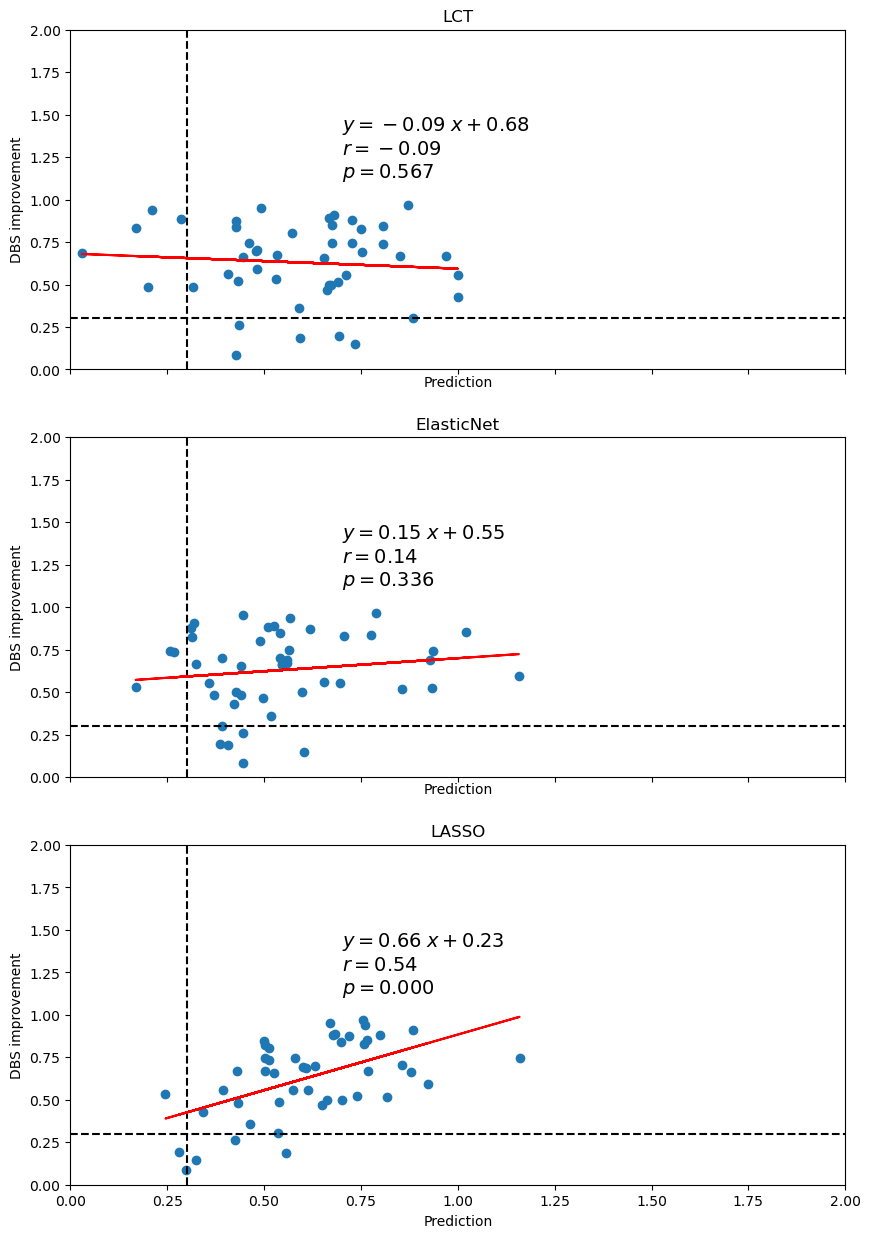

In [21]:
util.eval_prediction(np.vstack((pre_imp,
                               results_lsm,
                               results_ls)),
                               per_change,
                               ['LCT',
                                'ElasticNet',
                                'LASSO',

                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])